# **Artificial Intelligence Coursework 1**
## **Use of a Deep Learning Model for Binary Classification of Film Reviews**
### **By Gabriel Okafor**

#**Introduction**

This report details an experiment into the use of a deep learning model for the binary classification of film reviews.

In the process of this experiment I used the "Universal machine learning workflow" as outlined by Francois Chollet, paraphrasing or summarising this as follows:

1. Defining the problem and choosing a dataset
2. Choosing a measurement of success
3. Choosing an evaluation protocol
4. Preparing/preprocessing the dataset
5. Develop a model that performs better than baseline i.e. with "statisical power"
6. Overfit the model
7. Regularise the model
8. Retrain the model on training set
9. Evaluate model on unseen set <br>
*(Chollet, 14.1.5 The universal machine learning workflow 2021)*

Before beginning this procedure, the necessary modules and libraries must be imported. 



In [51]:
# Import / initialise modules and libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from tensorflow.keras import models
from tensorflow.keras import layers

from keras import optimizers
from keras import losses
from keras import regularizers

#**Defining the problem and dataset**


##**Defining the problem**


This investigation's aim was to discover whether a deep learning model could be effectively used in the task of "binary classification" - i.e. the sorting of data into strictly one of two classes, e.g. "Yes or No", "0 or 1", etc - on a dataset of film reviews, sorting them into either positive or negative sentiment. The following hypotheses were assumed:

1. A binary classification network can be used to classify film reviews into positive and negative sentiment with a reasonable prediction accuracy, given the inputs (film reviews)
2. The data available for use would be enough for a machine learning model to learn the relationship with inputs (film reviews) and targets (sentiment)

##**Choosing a dataset**

###**The IMDB dataset**

To this end, the Keras IDMB movie review sentiment classifcation dataset was chosen. As outlined by (Maas 2022), this dataset is "a collection of 50,000 reviews from IMDB", containing "an even number of positive and negative reviews". The reviews are "highly polarized" - i.e. "a negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10". There are no neutral reviews.

This dataset's spread of labels - one where every datapoint can be identified as being in one of two categories - makes it highly suitable for an experiment into the task of binary classification.

###**Explained**

In [52]:
# Import the dataset
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data()

This dataset was preprocessed by its creators prior to this experiment. Each review is "encoded as a list of word indexes (integers)", with words being "indexed by [their] overall frequency in the dataset" - i.e. "the integer '3' encodes the 3rd most frequent word in the data", "2" would encode the 2nd most frequent word, etc. (Keras 2022)

This functionality is demonstated below.


In [53]:
import random 

#Give the word index a more convenient reference variable
imdbDict = imdb.get_word_index()

#Exposition
print("By accessing its attributes and contents, we can see that the word index of our dataset is of the dictionary class: ")
#Print the type of our word index variable (imdbDict)
print(str(type(imdbDict)))
#newline
print("\n") 

#Initialise an empty array
randomKeys = []
#Fill this array with six random keys from our imdbDict
for i in range (6):
  randomKeys.append(random.choice(list(imdbDict.keys())))

#Exposition
print("Where, for example; ")

#Print the key and corresponding integer value in the full range of imdbDict
#(cont.) where a given key matches one of the strings in our randomKeys array

for key, value in imdbDict.items():
  if key in randomKeys:
    print("The word " + key + " corresponds to the integer: ", value)

#newline
print("\n")

#Select a random datapoint - a review - from our training data
randomReview = train_data[np.random.randint(0,25000)]
#Print its contents
print("This is a random review encoded into integers: ")
print(randomReview)

#Create an inverted version of imdbDict - mapping our integers back to their original words
inverted_imdbDict = dict((value, key) for (key, value) in imdbDict.items())

#Process our random reviews according to this inverted dictionary
randomReviewDecoded = " ".join(inverted_imdbDict.get(i-3,"?") for i in randomReview)

#Print the result
print("This is that same review decoded: ")
print(randomReviewDecoded)


By accessing its attributes and contents, we can see that the word index of our dataset is of the dictionary class: 
<class 'dict'>


Where, for example; 
The word seeber's corresponds to the integer:  63053
The word losses corresponds to the integer:  10937
The word apanowicz corresponds to the integer:  48553
The word brother' corresponds to the integer:  33812
The word racial corresponds to the integer:  4343
The word damaso corresponds to the integer:  86976


This is a random review encoded into integers: 
[1, 13, 40, 108, 15, 92, 1754, 4, 801, 654, 277, 5, 198, 61, 293, 282, 18, 61, 4034, 7, 14, 20, 2676, 59807, 4156, 5, 41, 118, 464, 12572, 7467, 26, 3553, 11, 7697, 18, 22390, 10209, 103, 6, 5595, 28352, 15132, 11, 8, 4, 10770, 5963, 4, 22, 127, 6, 1156, 292, 7, 1895, 797, 3099, 17, 8, 726, 42, 63, 7, 4, 539, 16, 574, 5, 988, 11066, 9, 404, 17, 68, 2928, 2408, 17790, 2508, 505, 11, 6, 1307, 239, 17, 27, 53, 243, 40584, 322, 37281, 37, 9, 82, 35, 4817, 13, 657, 4, 539, 69, 77, 52

#**Choosing measurements of success**

For this experiment, two measures of success were chosen.

The first was classification accuracy, defined "informally" as the "fraction of predictions our model got right" - i.e. $Correct Predictions/Total Predictions $   (Google 2022).

The second was the loss function "binary cross-entropy", a common choice for problems involving binary classification. 

Given that this was an experiment into binary classification, it was determined that no metrics more complicated than these would be necessary. They would be used for performance on training and validation data, as well as for assessing the performance of the final model on unseen data.

Both metrics would be output as floating point values from 0.0 to 1.0, with accuracy expressing a percentage (e.g. $0.54 == 54\%$) of correct guesses and loss being used as a reference value for the model to adjust itself.

#**Choosing an evaluation protocol**

For the purposes of evaluation, we would split our total set into three distinct sets
1. A training set (To train our unprepared model)
2. An evaluation set (To evaluate the training of our model while we tune our hyperparameters)
3. A testing test (To evaluate the training of our final model )

A total dataset of 50,000 samples, would be split into three sets - one training set, one evaluation, and one final testing set.
The first 10,000 samples would constitute the evaluation set; the next 15,000 the training set; and the last 25,000 the testing set.

#**Preparing / Preprocessing our data**

First, the dataset had to be imported. Then it was split it into two equally sized "training" and "test" datasets. We streamline our data by only including the 10,000 most used words in the datasets - this is what "num_words" indicates.

In [54]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

The lists of integers that the currently constitute our training and test datasets cannot be processed by a neural network. The data was made accessible to our network through multi-hot encoding. (Chollet 2021)

In [ ]:
def vectorise_sequences(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension)) 
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1.
  return results


In [58]:
#Vectorise our training/test data and their associated labels/targets

#Vectorise data
x_train = vectorise_sequences(train_data)
x_test = vectorise_sequences(test_data)

#Vectorise targets - simply converting our integer labels (e.g. "1") into
#(cont.) floating point values (e.g. "1.0") 
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

Now the training and test sets could also be declared, as described previously.

In [83]:
x_val = x_train[:10000]
partial_x_train = x_train[15000:]
y_val = y_train[:10000]
partial_y_train = y_train[15000:]

#**Plotting functions**

Some functions were defined to make the process of evaluating model data output more easily.



In [60]:
#from matplotlib.colors import LinearSegmentedColormap
def displayResults(mHist, withTable = False):

    ## --- Plot our training loss against our validation loss --- ##
  plt.clf() #clear the plot
  mHistDict = mHist.history #assign a variable for our model history
  lossValues = mHistDict["loss"] #assign a variable for our model loss
  validationLossValues = mHistDict["val_loss"] #assign a variable for our validation loss
  numEpochs = range(1, len(lossValues) + 1) #calculate our number of epochs

  #plot our training and validation loss against epochs - i.e. over time
  plt.plot(numEpochs, lossValues, "bo", label="Training loss") 
  plt.plot(numEpochs, validationLossValues, "b", label="Validation loss")
  #label our graph and its axes
  plt.title("Training & validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  #Display our graph with legend
  plt.legend()
  plt.show()

    ## --- Plot our training accuracy against our validation accuracy --- #
  plt.clf() #clear the plot
  accuracy = mHistDict["accuracy"] #assign a variable for our model accuracy
  val_accuracy = mHistDict["val_accuracy"] #assign a variable for our model validation accuracy
  numEpochs = range(1, len(mHistDict["loss"]) + 1) #calculate our number of epochs - our x-axis
  plt.plot(numEpochs, accuracy, "bo", label="Training Accuracy")
  plt.plot(numEpochs, val_accuracy, "b", label="Validation Accuracy")
  plt.title("Training & validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  # If the user wants to generate a table with their graphs, do the following
  if(withTable):
    ## --- Create a table of values comparing optimal and final values --- ##
    ## --- (cont.) of accuracy and loss for training and validation sets. --- ##

    valAccArr = mHistDict["val_accuracy"] #assign a variable for our model's validation accuracy
    maxValAcc = np.amax(valAccArr) #find out maximal validation accuracy
    finValAcc = valAccArr[-1] #get last validation accuracy
    
    valLossArr = mHistDict["val_loss"] #assign a variable for our model's validation loss
    minValLoss = np.amin(valLossArr) #get the smallest loss value
    finValLoss = valLossArr[-1] #get the final loss value

    maxAcc = np.amax(accuracy)
    finAcc = accuracy[-1]

    minLoss = np.amin(lossValues)
    finLoss = lossValues[-1]

    # Make an array containing the data we want to represent
    dataArr = [[maxAcc,finAcc,minLoss,finLoss],[maxValAcc,finValAcc,minValLoss,finValLoss]]
    # Make a list of our column labels
    cols = ("Maximal Accuracy","Final Accuracy","Minimal Loss","Final Loss")
  
    fit_table = plt.table(cellText=dataArr,
                        rowLabels=("Testing","Validation",),
                        colLabels=cols,
                        loc='center')
    
    # matplotlib forces us to attach a table to a plot, AKA a set of axes
      ##The below code cleans up our table by making this empty plot invisible
    axes = plt.gca()
    # Turn off the axes
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    # Turn off the plot box
    plt.box(on=None)
    # Make our table a bit bigger
    fit_table.scale(3.0, 3.5)
    # Show our table
    plt.show()

    #calculate accuracy and loss differentials 

    print("Accuracy differential == " + str(finValAcc - maxValAcc))
    print("Loss differential == " + str(minValLoss - finValLoss))

# This function takes two model histories and compares their validation loss and
  ##(cont.) accuracy against one another
def compareModelVal(mod1, mod2):
    ## --- Plot models validation loss against each other --- ##
  # Clear the plot
  plt.clf() 
  # Assign variables for our model histories
  mod1Hist = mod1.history 
  mod2Hist = mod2.history
  # Assign variables for our model validation losses
  mod1ValLoss = mod1Hist["val_loss"] 
  mod2ValLoss = mod2Hist["val_loss"] 
  # Calculate our number of epochs
  numEpochs = range(1, max(len(mod1ValLoss),len(mod2ValLoss)) + 1) 

  # Adjust arrays if they are of different sizes  
  ## This is to avoid broadcasting issues
  if len(mod1ValLoss) != len(mod2ValLoss):
    #if a is bigger than b, add empty values to b until they're the same size
    if len(mod2ValLoss) < len(mod1ValLoss):
      for i in range(len(mod1ValLoss) - len(mod2ValLoss)):
        mod2ValLoss.append(None)
    
    #if b is bigger than a, add empty values to b until they're the same size
    elif len(mod1ValLoss) < len(mod2ValLoss):
      for i in range(len(mod2ValLoss) - len(mod1ValLoss)):
        mod1ValLoss.append(None)

  plotX = 12
  plotY = 6
  # What is this? A plot for ants?
  plt.figure(figsize = (plotX,plotY))
  # Grid of 1 row and 2 columns, 1st item
  plt.subplot(1, 2, 1)
  plt.plot(numEpochs, mod1ValLoss, "r-.", label="Original Model Validation Loss") 
  plt.plot(numEpochs, mod2ValLoss, "b-", label="New Model Validation Loss")
  # Label our graph and its axes
  plt.title("Original vs New Model Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  # Display our graph with legend
  plt.legend()

      ## --- Plot models validation accuracy against each other --- ##
  #assign variables for our models' histories
  mod1Hist = mod1.history 
  mod2Hist = mod2.history
  #assign a variables for our models' losses
  mod1ValAcc = mod1Hist["val_accuracy"] 
  mod2ValAcc = mod2Hist["val_accuracy"]
  #calculate our number of epochs, using largest list
  numEpochs = range(1, max(len(mod1ValAcc),len(mod2ValAcc)) + 1) 

  #adjust arrays if they are of different sizes - this is to avoid broadcasting issues
  if len(mod1ValAcc) != len(mod2ValAcc):
    #if a is bigger than b, add empty values to b until they're the same size
    if len(mod2ValAcc) < len(mod1ValAcc):
      oldMod2ValAcc = mod2ValAcc
      for i in range(len(mod1ValAcc) - len(mod2ValAcc)):
        mod2ValAcc.append(None)

    #if b is bigger than a, add empty values to a until they're the same size
    elif len(mod1ValAcc) < len(mod2ValAcc):
      oldMod1ValAcc = mod1ValAcc
      for i in range(len(mod2ValAcc) - len(mod1ValAcc)):
        mod1ValAcc.append(None)
  
  #plot our graph
  #grid of 1 row and two columns, second item
  plt.subplot(1, 2, 2) 
  plt.plot(numEpochs, mod1ValAcc, "r-.", label="Original Model Validation Accuracy") 
  plt.plot(numEpochs, mod2ValAcc, "b-", label="New Model Validation Accuracy")
  #label our graph and its axes
  plt.title("Original vs New Model Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  #Display our graph with legend
  plt.legend()
  #Adjust layout, give items some breathing space
  plt.tight_layout(pad=4.0, w_pad=0.5, h_pad=1.0)
  plt.show()

#**Developing a model with statistical power / Overfitting the model**

##**Model 0**

###**Development**

In line with the "universal machine learning work flow", the first step in the actual programming of our model was to develop a model with stastical power - that is, the ability to beat in predication a "common sense, trivial baseline". As this was a task of binary classification - i.e. one where a result could only be one of two things - using a dataset split equally into positive and negative sentiments, a reasonable baseline to take would be an accuracy of $50\%$ - the chance of randomly guessing the sentiment of any given review in our dataset.

It was decided to follow common practices and develop a relatively simple model to begin with, with one Dense-Relu layer and a final sigmoid layer.

Epoch 1/20
20/20 [==============================] - 3s 114ms/step - loss: 0.5807 - accuracy: 0.7518 - val_loss: 0.4981 - val_accuracy: 0.8352
Epoch 2/20
20/20 [==============================] - 1s 50ms/step - loss: 0.4326 - accuracy: 0.8780 - val_loss: 0.4201 - val_accuracy: 0.8608
Epoch 3/20
20/20 [==============================] - 1s 72ms/step - loss: 0.3538 - accuracy: 0.9031 - val_loss: 0.3780 - val_accuracy: 0.8642
Epoch 4/20
20/20 [==============================] - 2s 87ms/step - loss: 0.2989 - accuracy: 0.9184 - val_loss: 0.3434 - val_accuracy: 0.8742
Epoch 5/20
20/20 [==============================] - 2s 89ms/step - loss: 0.2572 - accuracy: 0.9298 - val_loss: 0.3188 - val_accuracy: 0.8833
Epoch 6/20
20/20 [==============================] - 1s 61ms/step - loss: 0.2247 - accuracy: 0.9403 - val_loss: 0.3058 - val_accuracy: 0.8852
Epoch 7/20
20/20 [==============================] - 1s 51ms/step - loss: 0.1979 - accuracy: 0.9484 - val_loss: 0.2954 - val_accuracy: 0.8831
Epoch 8/20
2

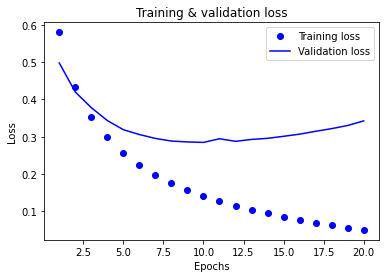

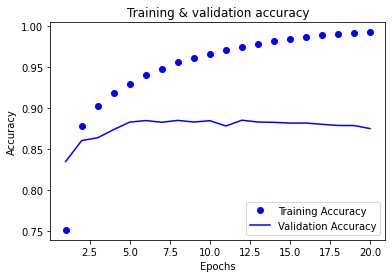

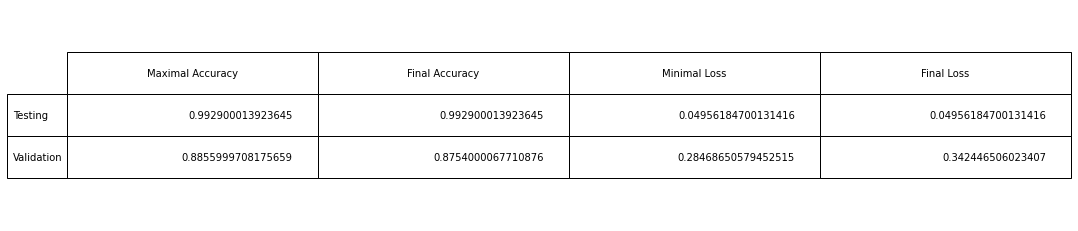

Accuracy differential == -0.010199964046478271
Loss differential == -0.057760000228881836


In [61]:
model0 = keras.Sequential([
 layers.Dense(8, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model0.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

#Make a variable to process results of training, and train the model
model0History = model0.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

#Show results
displayResults(model0History, True)

###**Conclusion**

With final training and validation accuracies of ~$99\%$ and ~$87\%$ respectively, it was clear that this model beats the given baseline prediction accuracy of ~$50\%$. 

While training accuracy and loss only improved towards the end of their epochs, validation accuracy and loss peaked early on and then degraded. From this we can deduce that the model was overfitting.

As such, the seperate step of developing a model which overfits would be un-necessary - it was, rather, appropriate to begin regularising and tuning the model.

It was hypothesised that reducing the network's complexity by reducing the number of layers used might reduce overfitting. 

A small movement of $1$ in the downward direction would be implemented, resulting in a unit quantity of $7$; if overfitting was reduced, more dramatic movements in this direction would be tested. If overfitting was increased, movement in the opposite direction (upwards/increasing units) would be considered.

#**Regularising and tuning the model**

##**Model 1 - Reduce units to 7**

###**Development** 

Epoch 1/20
20/20 [==============================] - 3s 110ms/step - loss: 0.5609 - accuracy: 0.7604 - val_loss: 0.4662 - val_accuracy: 0.8501
Epoch 2/20
20/20 [==============================] - 1s 48ms/step - loss: 0.3965 - accuracy: 0.8866 - val_loss: 0.3924 - val_accuracy: 0.8696
Epoch 3/20
20/20 [==============================] - 1s 52ms/step - loss: 0.3180 - accuracy: 0.9139 - val_loss: 0.3518 - val_accuracy: 0.8755
Epoch 4/20
20/20 [==============================] - 1s 57ms/step - loss: 0.2656 - accuracy: 0.9286 - val_loss: 0.3227 - val_accuracy: 0.8840
Epoch 5/20
20/20 [==============================] - 1s 50ms/step - loss: 0.2283 - accuracy: 0.9388 - val_loss: 0.3064 - val_accuracy: 0.8863
Epoch 6/20
20/20 [==============================] - 1s 55ms/step - loss: 0.1981 - accuracy: 0.9500 - val_loss: 0.3062 - val_accuracy: 0.8776
Epoch 7/20
20/20 [==============================] - 1s 48ms/step - loss: 0.1752 - accuracy: 0.9589 - val_loss: 0.3012 - val_accuracy: 0.8838
Epoch 8/20
2

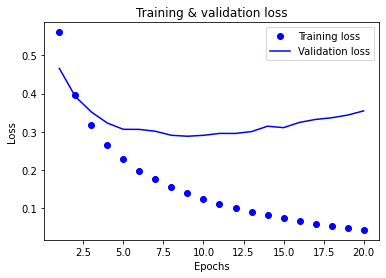

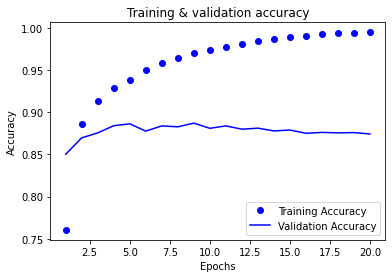

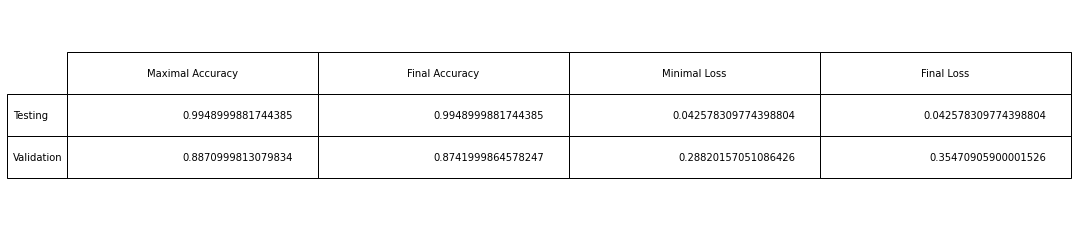

Accuracy differential == -0.012899994850158691
Loss differential == -0.066507488489151


<Figure size 432x288 with 0 Axes>

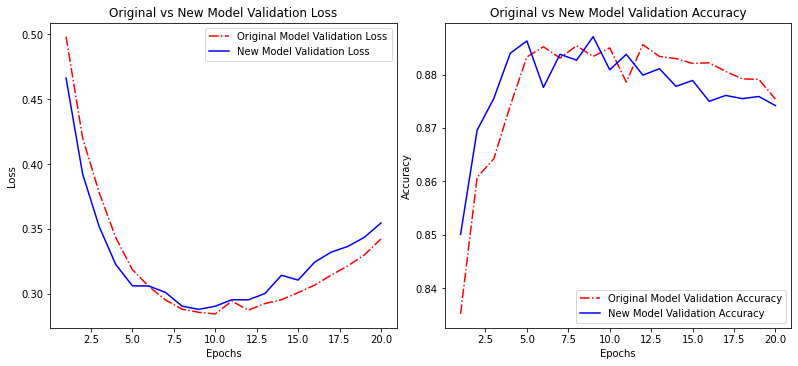

In [63]:
model1 = keras.Sequential([
 layers.Dense(7, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model1.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model1History = model1.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model1History, True)

# Compare validation data of this and the previous model
compareModelVal(model0History,model1History)


###**Conclusion**


Reducing the number of units to $7$ resulted in an increase in the model's final validation accuracy as well as a decrease in the model's final validation loss. Overall, this could be characterised as a decrease in overfitting.

The decision here was made to reduce the units hyperparameter until the model showed no further improvements to validation loss and accuracy. This was explored in the next model, with a decrease of $-2$.

##**Model 2 - Reduce units to 5**

###**Development** 

Epoch 1/20
20/20 [==============================] - 3s 107ms/step - loss: 0.5898 - accuracy: 0.7635 - val_loss: 0.5150 - val_accuracy: 0.8301
Epoch 2/20
20/20 [==============================] - 1s 67ms/step - loss: 0.4515 - accuracy: 0.8743 - val_loss: 0.4489 - val_accuracy: 0.8450
Epoch 3/20
20/20 [==============================] - 2s 88ms/step - loss: 0.3781 - accuracy: 0.8987 - val_loss: 0.3930 - val_accuracy: 0.8688
Epoch 4/20
20/20 [==============================] - 1s 54ms/step - loss: 0.3235 - accuracy: 0.9148 - val_loss: 0.3596 - val_accuracy: 0.8749
Epoch 5/20
20/20 [==============================] - 1s 52ms/step - loss: 0.2821 - accuracy: 0.9251 - val_loss: 0.3396 - val_accuracy: 0.8753
Epoch 6/20
20/20 [==============================] - 1s 43ms/step - loss: 0.2496 - accuracy: 0.9345 - val_loss: 0.3215 - val_accuracy: 0.8799
Epoch 7/20
20/20 [==============================] - 1s 48ms/step - loss: 0.2231 - accuracy: 0.9424 - val_loss: 0.3070 - val_accuracy: 0.8846
Epoch 8/20
2

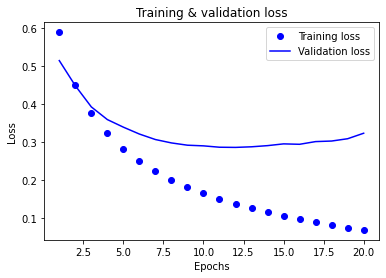

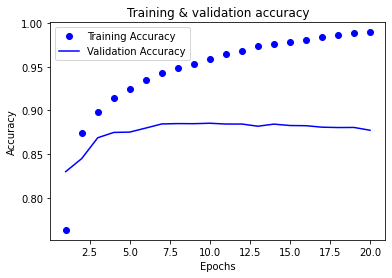

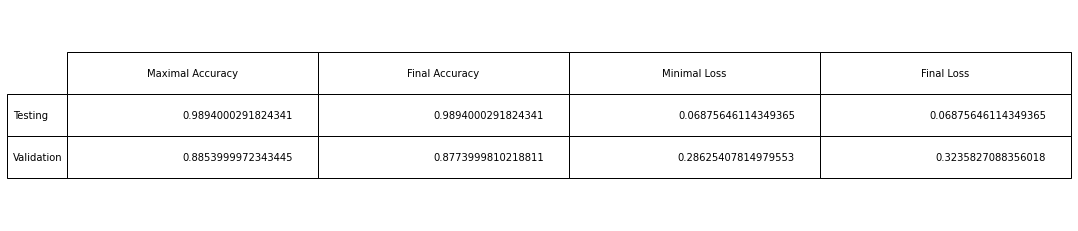

Accuracy differential == -0.008000016212463379
Loss differential == -0.037328630685806274


<Figure size 432x288 with 0 Axes>

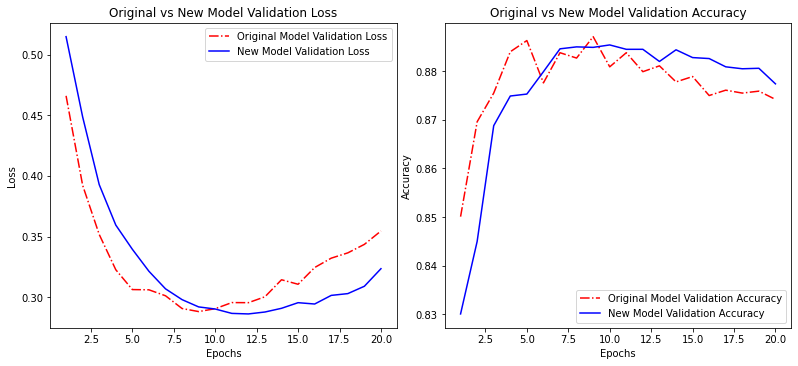

In [64]:
model2 = keras.Sequential([
 layers.Dense(5, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model2.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model2History = model2.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model2History,True)
compareModelVal(model1History,model2History)


###**Conclusions**

Reducing the number of units to $5$ resulted in an even more dramatic reduction in overfitting as defined in previous conclusions. The process of reducing unit number therefore continued. This time, it would be reduced to $3$, a change of $-2$. This was expected to introduce underfitting.

##**Model 3 - Reduce units to 3**




###**Development** 

Epoch 1/20
30/30 [==============================] - 2s 48ms/step - loss: 0.5580 - accuracy: 0.7879 - val_loss: 0.4753 - val_accuracy: 0.8486
Epoch 2/20
30/30 [==============================] - 1s 45ms/step - loss: 0.4159 - accuracy: 0.8801 - val_loss: 0.4006 - val_accuracy: 0.8645
Epoch 3/20
30/30 [==============================] - 1s 45ms/step - loss: 0.3426 - accuracy: 0.9013 - val_loss: 0.3553 - val_accuracy: 0.8741
Epoch 4/20
30/30 [==============================] - 1s 46ms/step - loss: 0.2935 - accuracy: 0.9137 - val_loss: 0.3278 - val_accuracy: 0.8781
Epoch 5/20
30/30 [==============================] - 1s 46ms/step - loss: 0.2583 - accuracy: 0.9240 - val_loss: 0.3089 - val_accuracy: 0.8839
Epoch 6/20
30/30 [==============================] - 1s 47ms/step - loss: 0.2311 - accuracy: 0.9322 - val_loss: 0.2932 - val_accuracy: 0.8877
Epoch 7/20
30/30 [==============================] - 1s 48ms/step - loss: 0.2089 - accuracy: 0.9396 - val_loss: 0.2843 - val_accuracy: 0.8892
Epoch 8/20
30

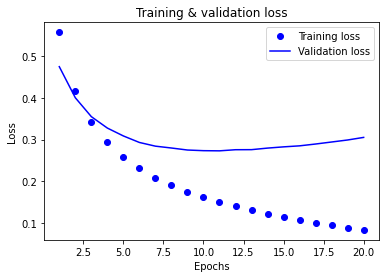

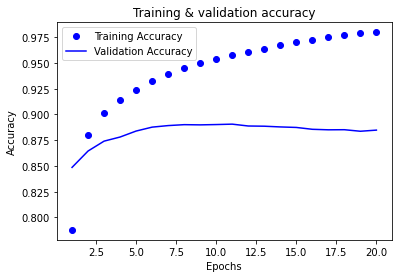

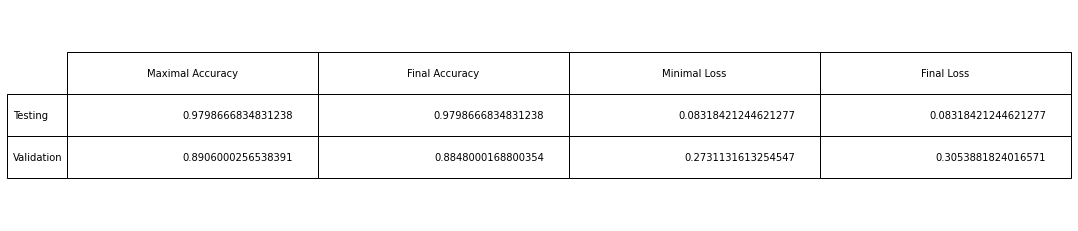

Accuracy differential == -0.005800008773803711
Loss differential == -0.03227502107620239


<Figure size 432x288 with 0 Axes>

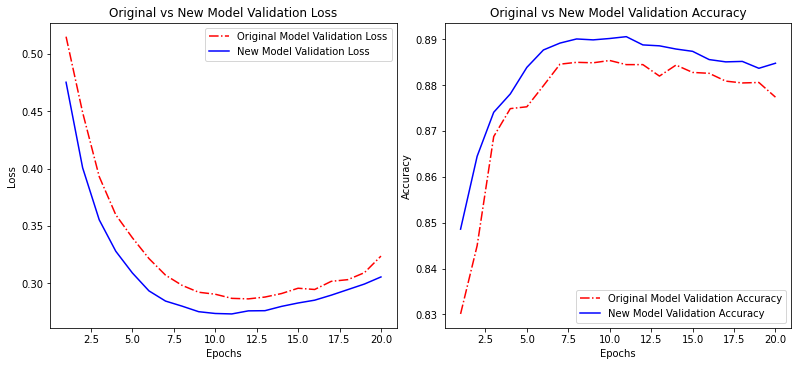

In [70]:
model3 = keras.Sequential([
 layers.Dense(3, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model3.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model3History = model3.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model3History, True)
compareModelVal(model2History,model3History)

###**Conclusions** 

Reducing the number of units to $3$ surprisingly resulted in an even further decrease in overfitting as defined in previous conclusions.

It was hypothesised that reducing unit quantity further might again decrease overfitting. This time, it would be reduced to $2$, a change of $-1$ 

##**Model 4 - Reduce units to 2**

###**Development** 

Epoch 1/20
30/30 [==============================] - 2s 62ms/step - loss: 0.6021 - accuracy: 0.7521 - val_loss: 0.5299 - val_accuracy: 0.8243
Epoch 2/20
30/30 [==============================] - 1s 45ms/step - loss: 0.4727 - accuracy: 0.8677 - val_loss: 0.4512 - val_accuracy: 0.8579
Epoch 3/20
30/30 [==============================] - 1s 46ms/step - loss: 0.3983 - accuracy: 0.8893 - val_loss: 0.3995 - val_accuracy: 0.8697
Epoch 4/20
30/30 [==============================] - 1s 46ms/step - loss: 0.3445 - accuracy: 0.9036 - val_loss: 0.3627 - val_accuracy: 0.8762
Epoch 5/20
30/30 [==============================] - 1s 46ms/step - loss: 0.3047 - accuracy: 0.9138 - val_loss: 0.3379 - val_accuracy: 0.8810
Epoch 6/20
30/30 [==============================] - 1s 41ms/step - loss: 0.2744 - accuracy: 0.9217 - val_loss: 0.3193 - val_accuracy: 0.8857
Epoch 7/20
30/30 [==============================] - 1s 42ms/step - loss: 0.2496 - accuracy: 0.9283 - val_loss: 0.3050 - val_accuracy: 0.8875
Epoch 8/20
30

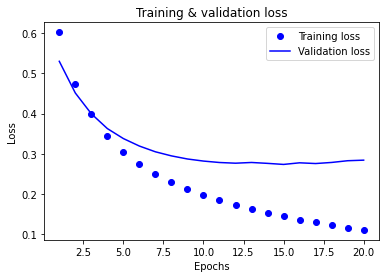

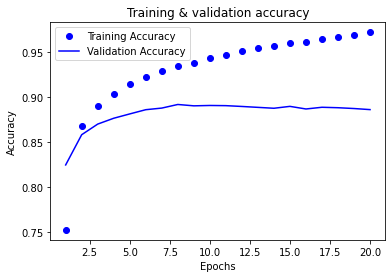

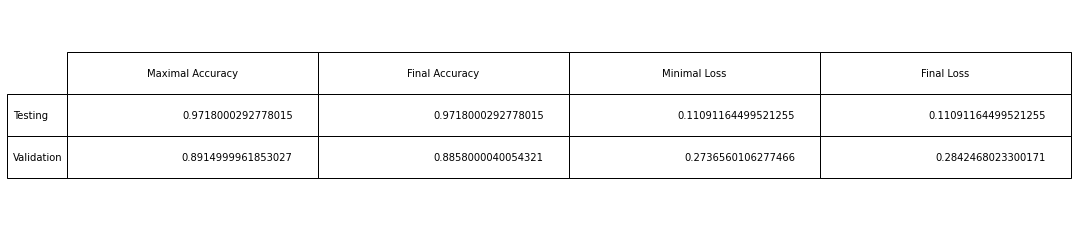

Accuracy differential == -0.0056999921798706055
Loss differential == -0.010590791702270508


<Figure size 432x288 with 0 Axes>

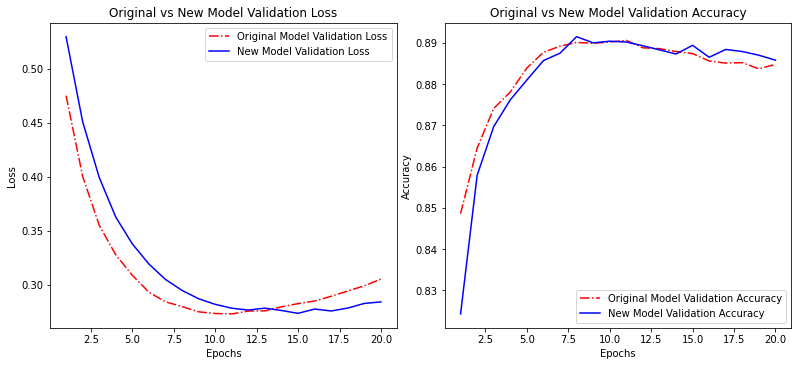

In [71]:
model4 = keras.Sequential([
 layers.Dense(2, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model4.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])


model4History = model4.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model4History, True)
compareModelVal(model3History,model4History)

###**Conclusions**

Reducing the number of units to $2$ resulted in a further decrease in overfitting as defined in previous conclusions. 

As per the on-going process, units would be reduced again - now to $1$, a change of $-1$ 

##**Model 5 - Reduce units to 1**

###**Development** 

Epoch 1/20
30/30 [==============================] - 2s 37ms/step - loss: 0.6387 - accuracy: 0.6627 - val_loss: 0.5908 - val_accuracy: 0.7483
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.5596 - accuracy: 0.7763 - val_loss: 0.5501 - val_accuracy: 0.8106
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.5182 - accuracy: 0.8227 - val_loss: 0.5230 - val_accuracy: 0.8166
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.4889 - accuracy: 0.8529 - val_loss: 0.5044 - val_accuracy: 0.8277
Epoch 5/20
30/30 [==============================] - 1s 28ms/step - loss: 0.4652 - accuracy: 0.8731 - val_loss: 0.4896 - val_accuracy: 0.8436
Epoch 6/20
30/30 [==============================] - 1s 21ms/step - loss: 0.4453 - accuracy: 0.8909 - val_loss: 0.4855 - val_accuracy: 0.8186
Epoch 7/20
30/30 [==============================] - 1s 22ms/step - loss: 0.4281 - accuracy: 0.8992 - val_loss: 0.4730 - val_accuracy: 0.8356
Epoch 8/20
30

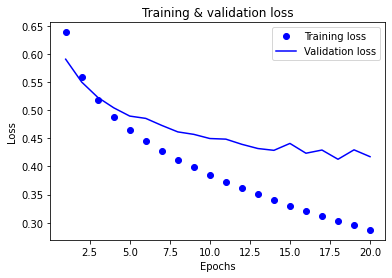

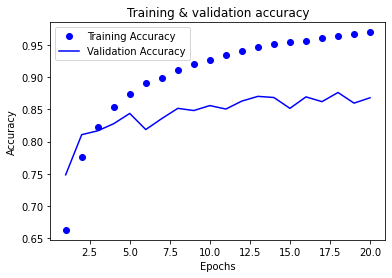

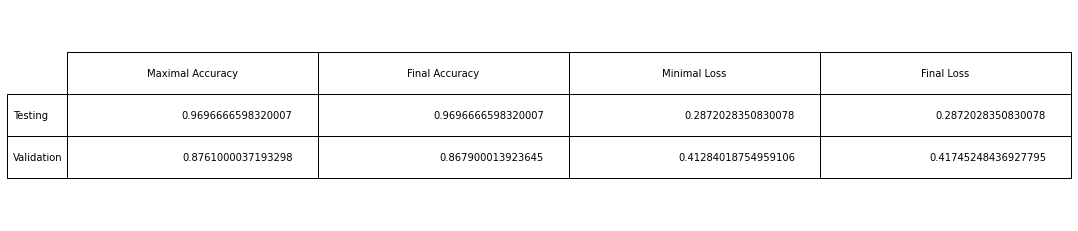

Accuracy differential == -0.008199989795684814
Loss differential == -0.00461229681968689


<Figure size 432x288 with 0 Axes>

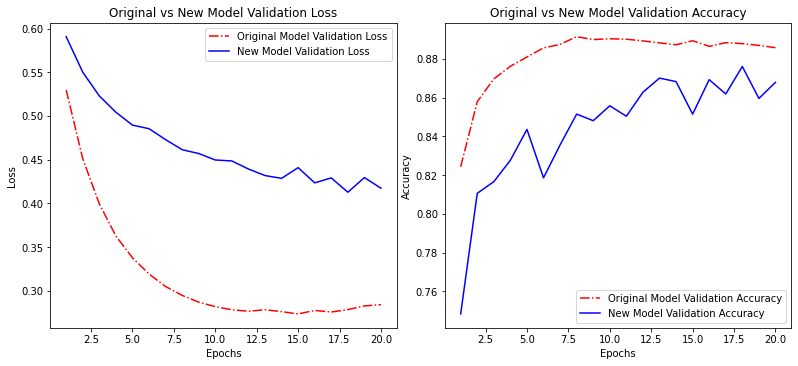

In [72]:
model5 = keras.Sequential([
 layers.Dense(1, activation="relu"),
 layers.Dense(1, activation="sigmoid")
])


model5.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model5History = model5.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model5History, True)
compareModelVal(model4History,model5History)

###**Conclusions**

Reducing the number of units to $1$ resulted in a dramatic increase in validation loss as well as a more moderate decrease in validation accuracy. It was therefore apparent that $2$ was the optimal value for this single layer model's unit hyperparameter. 

The focus would now change to tweaking other settings in an attempt to improve the model's performance and reduce overfitting, using Model 4 as a baseline for improvement. First, experiments would be made into adding layers.

##**Model 6 - Adding a second Dense layer**

###**Development** 

Epoch 1/20
30/30 [==============================] - 2s 58ms/step - loss: 0.6205 - accuracy: 0.6501 - val_loss: 0.5852 - val_accuracy: 0.6427
Epoch 2/20
30/30 [==============================] - 1s 39ms/step - loss: 0.5353 - accuracy: 0.7833 - val_loss: 0.5353 - val_accuracy: 0.7576
Epoch 3/20
30/30 [==============================] - 1s 36ms/step - loss: 0.4893 - accuracy: 0.8432 - val_loss: 0.5087 - val_accuracy: 0.7967
Epoch 4/20
30/30 [==============================] - 1s 38ms/step - loss: 0.4563 - accuracy: 0.8747 - val_loss: 0.4847 - val_accuracy: 0.8446
Epoch 5/20
30/30 [==============================] - 1s 44ms/step - loss: 0.4305 - accuracy: 0.8997 - val_loss: 0.4739 - val_accuracy: 0.8431
Epoch 6/20
30/30 [==============================] - 1s 41ms/step - loss: 0.4086 - accuracy: 0.9175 - val_loss: 0.4602 - val_accuracy: 0.8643
Epoch 7/20
30/30 [==============================] - 1s 40ms/step - loss: 0.3893 - accuracy: 0.9316 - val_loss: 0.4696 - val_accuracy: 0.8367
Epoch 8/20
30

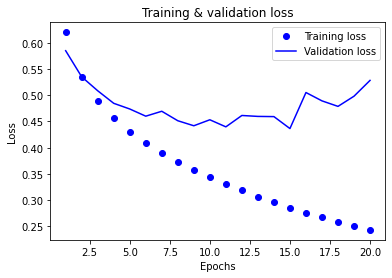

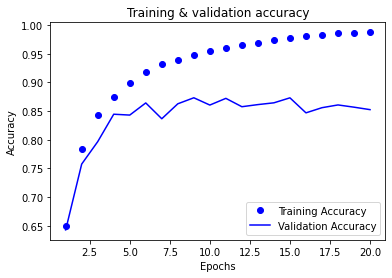

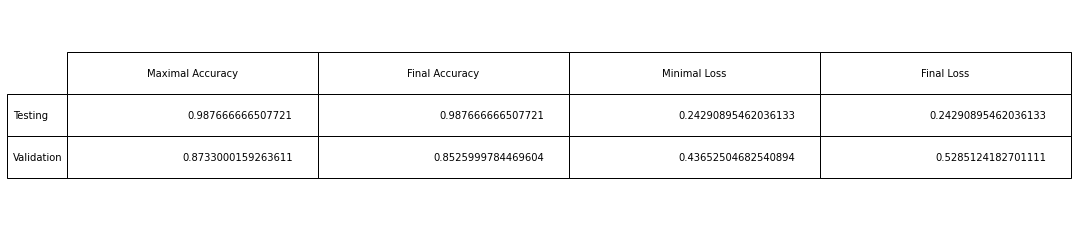

Accuracy differential == -0.020700037479400635
Loss differential == -0.09198737144470215


<Figure size 432x288 with 0 Axes>

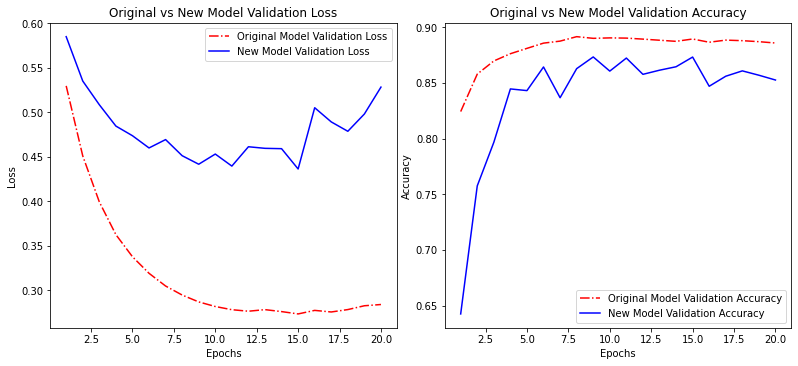

In [73]:
model6 = keras.Sequential([
  layers.Dense(2, activation="relu"),
  layers.Dense(2, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])


model6.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model6History = model6.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model6History, True)
compareModelVal(model4History,model6History)

###**Conclusions** 

Adding a new Dense layer resulted in both a dramatic increase in validation loss and decrease in validation accuracy. This change would, therefore, be discarded.

It was hypothesised that using a dropout layer would improve performance instead - this change was explored next.

##**Model 7 - Adding a dropout layer**

###**Development** 

Epoch 1/20
30/30 [==============================] - 2s 47ms/step - loss: 0.6574 - accuracy: 0.7168 - val_loss: 0.6251 - val_accuracy: 0.7973
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.5943 - accuracy: 0.7834 - val_loss: 0.5700 - val_accuracy: 0.8374
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.5412 - accuracy: 0.8000 - val_loss: 0.5214 - val_accuracy: 0.8501
Epoch 4/20
30/30 [==============================] - 1s 50ms/step - loss: 0.4930 - accuracy: 0.8137 - val_loss: 0.4777 - val_accuracy: 0.8574
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.4512 - accuracy: 0.8234 - val_loss: 0.4409 - val_accuracy: 0.8643
Epoch 6/20
30/30 [==============================] - 1s 42ms/step - loss: 0.4187 - accuracy: 0.8283 - val_loss: 0.4109 - val_accuracy: 0.8696
Epoch 7/20
30/30 [==============================] - 1s 44ms/step - loss: 0.3901 - accuracy: 0.8378 - val_loss: 0.3854 - val_accuracy: 0.8742
Epoch 8/20
30

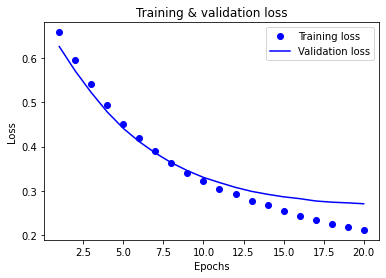

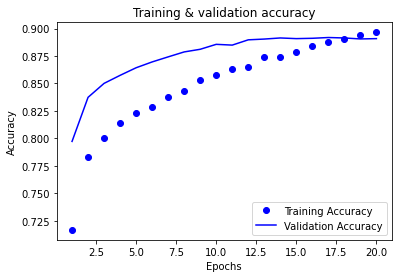

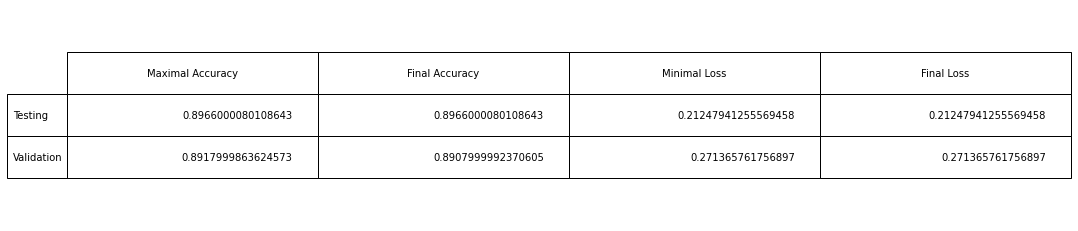

Accuracy differential == -0.0009999871253967285
Loss differential == 0.0


<Figure size 432x288 with 0 Axes>

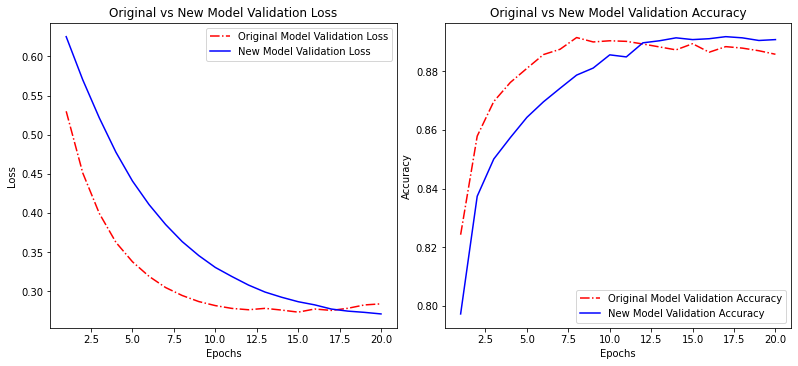

In [75]:
model7 = keras.Sequential([
  layers.Dense(2, activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

model7.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model7History = model7.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model7History, True)
compareModelVal(model4History,model7History)

###**Conclusions** 

Adding a Dropout layer at rate $0.1$ provided marginal improvements in both validation loss and validation accuracy.

It was hypothesised that adding another dropout layer, as the first layer in the model, would further improve the model's performance. This hypothesis was explored next, with Model 7 as the new baseline.

##**Model 8 - Adding a second Dropout layer**

###**Development**

Epoch 1/20
30/30 [==============================] - 7s 179ms/step - loss: 0.6609 - accuracy: 0.6877 - val_loss: 0.6292 - val_accuracy: 0.8206
Epoch 2/20
30/30 [==============================] - 3s 87ms/step - loss: 0.6018 - accuracy: 0.7886 - val_loss: 0.5778 - val_accuracy: 0.8426
Epoch 3/20
30/30 [==============================] - 4s 121ms/step - loss: 0.5499 - accuracy: 0.8078 - val_loss: 0.5281 - val_accuracy: 0.8540
Epoch 4/20
30/30 [==============================] - 3s 92ms/step - loss: 0.5015 - accuracy: 0.8189 - val_loss: 0.4856 - val_accuracy: 0.8583
Epoch 5/20
30/30 [==============================] - 3s 101ms/step - loss: 0.4632 - accuracy: 0.8252 - val_loss: 0.4483 - val_accuracy: 0.8661
Epoch 6/20
30/30 [==============================] - 3s 86ms/step - loss: 0.4306 - accuracy: 0.8327 - val_loss: 0.4178 - val_accuracy: 0.8691
Epoch 7/20
30/30 [==============================] - 3s 95ms/step - loss: 0.4028 - accuracy: 0.8367 - val_loss: 0.3931 - val_accuracy: 0.8752
Epoch 8/20

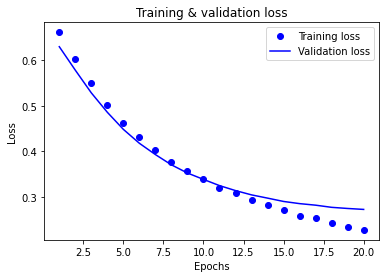

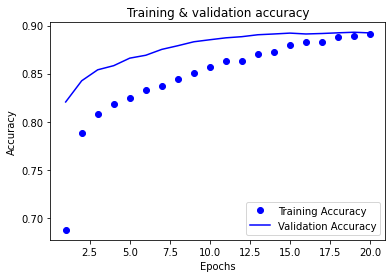

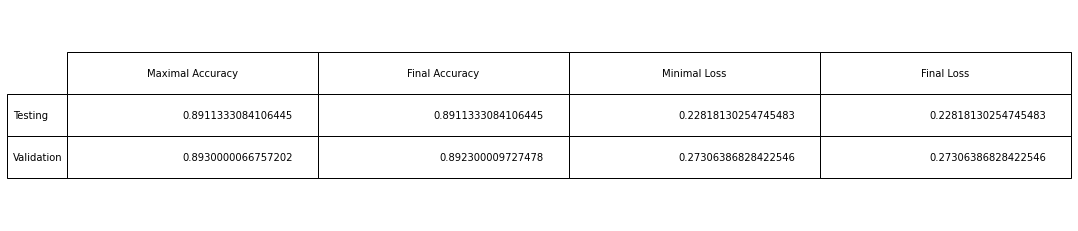

Accuracy differential == -0.0006999969482421875
Loss differential == 0.0


<Figure size 432x288 with 0 Axes>

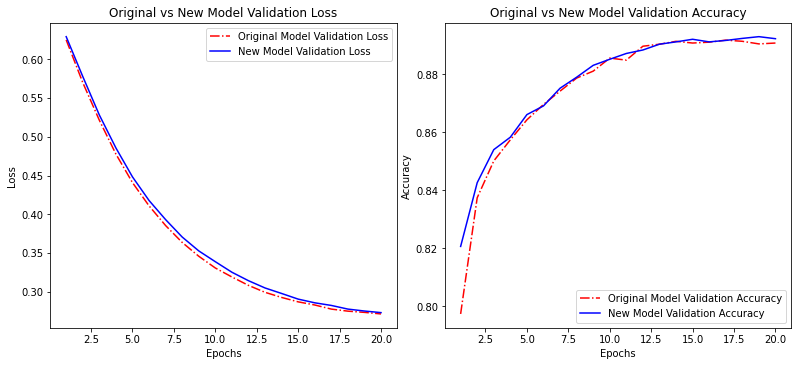

In [79]:
model8 = keras.Sequential([
  layers.Dropout(0.1),
  layers.Dense(2, activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

model8.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model8History = model8.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model8History, True)
compareModelVal(model7History,model8History)

###**Conclusions**

Adding a second drop-out layer gave further, marginal improvements to model performance. While these appeared to have come at the expense of some training accuracy, it was hypothesised that - noting that the loss and accuracy differentials (the differences between the minimal and final loss and accuracy values) had in one case dropped to $0$, and in the other come very close - increasing the number of epochs from $20$ to $30$ could increase the models effectiveness. This would be explored with model 8 as a baseline.

##**Model 9 - Increasing Epochs From 20 to 30**

###**Development**

Epoch 1/30
30/30 [==============================] - 4s 108ms/step - loss: 0.6340 - accuracy: 0.6517 - val_loss: 0.5857 - val_accuracy: 0.6920
Epoch 2/30
30/30 [==============================] - 3s 106ms/step - loss: 0.5632 - accuracy: 0.7631 - val_loss: 0.5471 - val_accuracy: 0.7456
Epoch 3/30
30/30 [==============================] - 3s 106ms/step - loss: 0.5258 - accuracy: 0.8157 - val_loss: 0.5202 - val_accuracy: 0.8011
Epoch 4/30
30/30 [==============================] - 3s 117ms/step - loss: 0.4974 - accuracy: 0.8471 - val_loss: 0.5016 - val_accuracy: 0.8240
Epoch 5/30
30/30 [==============================] - 4s 127ms/step - loss: 0.4762 - accuracy: 0.8685 - val_loss: 0.4862 - val_accuracy: 0.8523
Epoch 6/30
30/30 [==============================] - 4s 121ms/step - loss: 0.4575 - accuracy: 0.8833 - val_loss: 0.4751 - val_accuracy: 0.8519
Epoch 7/30
30/30 [==============================] - 4s 119ms/step - loss: 0.4403 - accuracy: 0.8963 - val_loss: 0.4667 - val_accuracy: 0.8521
Epoch 

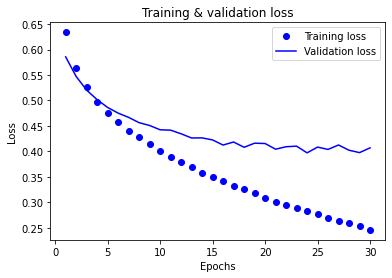

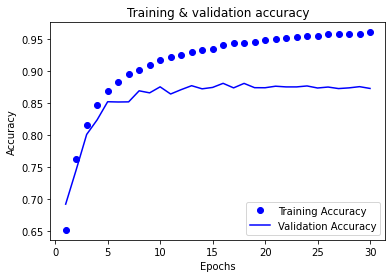

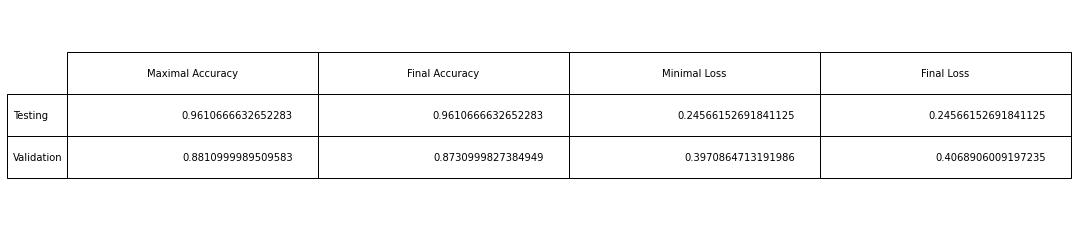

Accuracy differential == -0.008000016212463379
Loss differential == -0.009804129600524902


<Figure size 432x288 with 0 Axes>

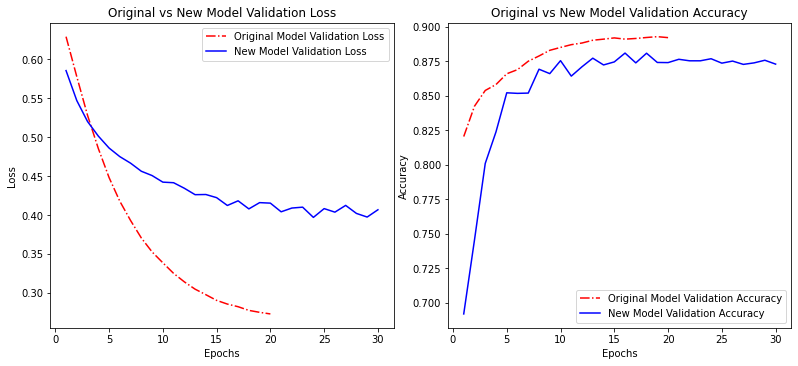

In [80]:
model9 = keras.Sequential([
  layers.Dropout(0.1),
  layers.Dense(2, activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

model9.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model9History = model9.fit(partial_x_train, partial_y_train, epochs=30,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model9History, True)
compareModelVal(model8History,model9History)

###**Conclusions**

Increasing the number of epochs reduced the performance of the model. This change was therefore discarded.

It was then hypothesised that the use of L1 or L2 regularisation could improve the performance of the model. These changes would be explored in the following experiments.

##**Model 10 - Adding L1 regularisation**

###**Development**

Epoch 1/20
30/30 [==============================] - 5s 125ms/step - loss: 0.7769 - accuracy: 0.6247 - val_loss: 0.6897 - val_accuracy: 0.7319
Epoch 2/20
30/30 [==============================] - 3s 84ms/step - loss: 0.6769 - accuracy: 0.7049 - val_loss: 0.6712 - val_accuracy: 0.8121
Epoch 3/20
30/30 [==============================] - 3s 104ms/step - loss: 0.6598 - accuracy: 0.7558 - val_loss: 0.6515 - val_accuracy: 0.8158
Epoch 4/20
30/30 [==============================] - 3s 87ms/step - loss: 0.6435 - accuracy: 0.7645 - val_loss: 0.6344 - val_accuracy: 0.8248
Epoch 5/20
30/30 [==============================] - 3s 96ms/step - loss: 0.6295 - accuracy: 0.7738 - val_loss: 0.6192 - val_accuracy: 0.8290
Epoch 6/20
30/30 [==============================] - 4s 123ms/step - loss: 0.6185 - accuracy: 0.7775 - val_loss: 0.6037 - val_accuracy: 0.8297
Epoch 7/20
30/30 [==============================] - 3s 102ms/step - loss: 0.6064 - accuracy: 0.7824 - val_loss: 0.5923 - val_accuracy: 0.8338
Epoch 8/2

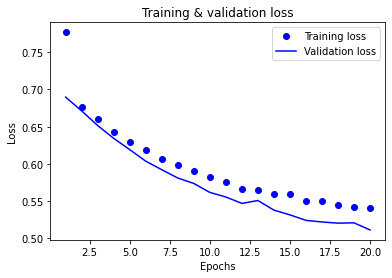

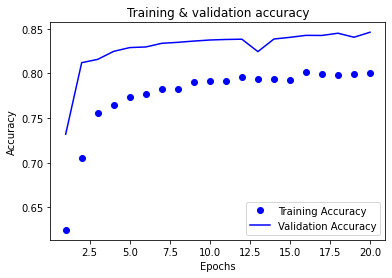

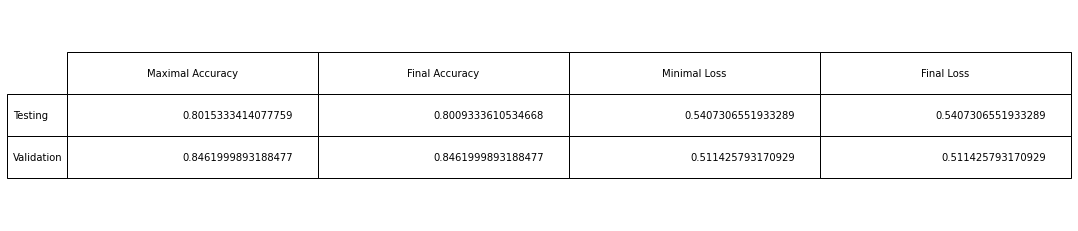

Accuracy differential == 0.0
Loss differential == 0.0


<Figure size 432x288 with 0 Axes>

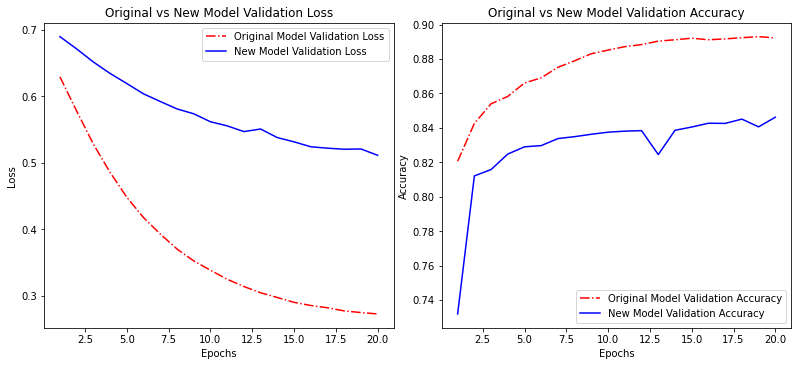

In [81]:
model10 = keras.Sequential([
  layers.Dropout(0.1),
  layers.Dense(2, kernel_regularizer=regularizers.l1(0.002), activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

model10.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model10History = model10.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model10History, True)
compareModelVal(model8History,model10History)

###**Conclusions**

Adding L1 regularisation significantly reduced the model's performance by all metrics. This change was hastily discarded.

L2 regularisation would be explored next.

##**Model 11 - Adding L2 regularisation**

###**Development**

Epoch 1/20
30/30 [==============================] - 4s 122ms/step - loss: 0.6618 - accuracy: 0.6121 - val_loss: 0.6369 - val_accuracy: 0.6779
Epoch 2/20
30/30 [==============================] - 3s 93ms/step - loss: 0.6172 - accuracy: 0.7152 - val_loss: 0.6076 - val_accuracy: 0.7196
Epoch 3/20
30/30 [==============================] - 3s 86ms/step - loss: 0.5888 - accuracy: 0.7643 - val_loss: 0.5866 - val_accuracy: 0.7356
Epoch 4/20
30/30 [==============================] - 3s 91ms/step - loss: 0.5680 - accuracy: 0.7967 - val_loss: 0.5686 - val_accuracy: 0.7736
Epoch 5/20
30/30 [==============================] - 3s 89ms/step - loss: 0.5507 - accuracy: 0.8219 - val_loss: 0.5539 - val_accuracy: 0.8064
Epoch 6/20
30/30 [==============================] - 3s 89ms/step - loss: 0.5357 - accuracy: 0.8348 - val_loss: 0.5421 - val_accuracy: 0.8321
Epoch 7/20
30/30 [==============================] - 3s 92ms/step - loss: 0.5253 - accuracy: 0.8475 - val_loss: 0.5319 - val_accuracy: 0.8242
Epoch 8/20
3

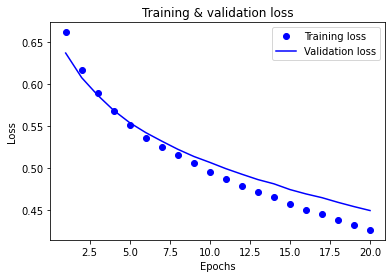

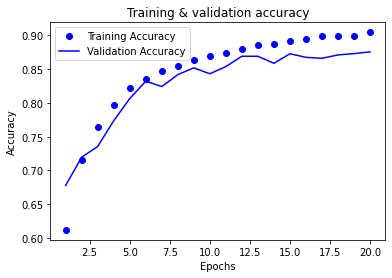

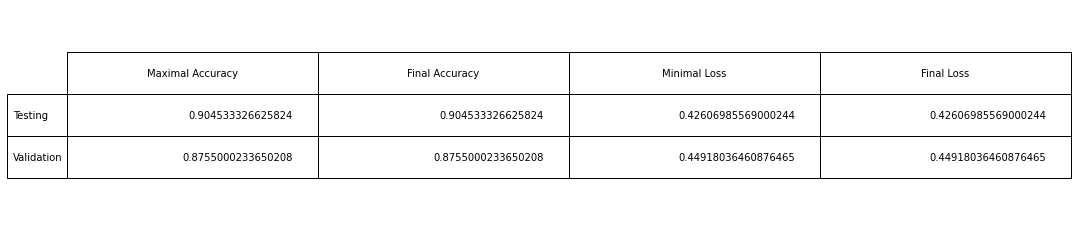

Accuracy differential == 0.0
Loss differential == 0.0


<Figure size 432x288 with 0 Axes>

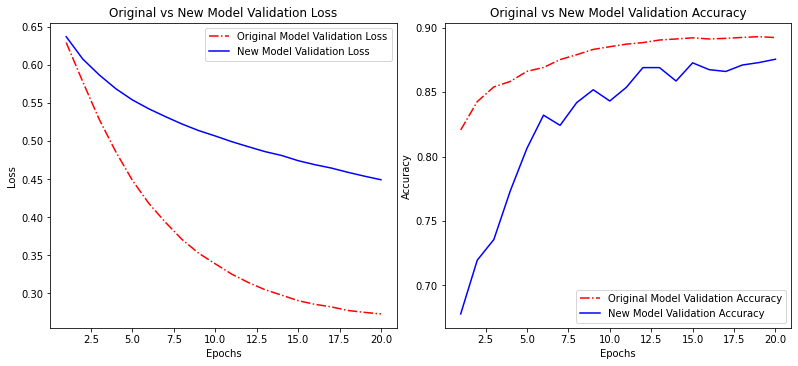

In [82]:
model11 = keras.Sequential([
  layers.Dropout(0.1),
  layers.Dense(2, kernel_regularizer=regularizers.l2(0.002), activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

model11.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])

model11History = model11.fit(partial_x_train, partial_y_train, epochs=20,
 batch_size=512, validation_data=(x_val, y_val))

displayResults(model11History, True)
compareModelVal(model8History,model11History)

###**Conclusions**

L2 regularisation also significantly reduced the model's performance - it was discarded.

At this stage, Model 8 was deemed as being as close to an optimal model as could be developed under time constraints; the decision was made to test it on the unseen dataset.

#**Final Model - 2 Dropout layers with Frequency 0.1, 1 Dense-Relu layer with 2 units, 20 Epochs**

###**Development**

In [85]:
finalModel = keras.Sequential([
  layers.Dropout(0.1),
  layers.Dense(2, activation="relu"),
  layers.Dropout(0.1),
  layers.Dense(1, activation="sigmoid")
])

finalModel.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])


finalModel.fit(x_train, y_train, epochs=20,batch_size=512)
resser = finalModel.evaluate(x_test,y_test)
print("Unseen Data Evaluation = " + str(resser))

Epoch 1/20
49/49 [==============================] - 4s 77ms/step - loss: 0.5322 - accuracy: 0.7492
Epoch 2/20
49/49 [==============================] - 5s 111ms/step - loss: 0.3966 - accuracy: 0.8269
Epoch 3/20
49/49 [==============================] - 4s 83ms/step - loss: 0.3430 - accuracy: 0.8478
Epoch 4/20
49/49 [==============================] - 4s 85ms/step - loss: 0.3090 - accuracy: 0.8599
Epoch 5/20
49/49 [==============================] - 4s 82ms/step - loss: 0.2864 - accuracy: 0.8675
Epoch 6/20
49/49 [==============================] - 4s 82ms/step - loss: 0.2706 - accuracy: 0.8733
Epoch 7/20
49/49 [==============================] - 4s 85ms/step - loss: 0.2569 - accuracy: 0.8781
Epoch 8/20
49/49 [==============================] - 4s 84ms/step - loss: 0.2509 - accuracy: 0.8789
Epoch 9/20
49/49 [==============================] - 4s 78ms/step - loss: 0.2381 - accuracy: 0.8838
Epoch 10/20
49/49 [==============================] - 4s 82ms/step - loss: 0.2307 - accuracy: 0.8866
Epoch 11

#**Final Conclusion**

The final model performed on the unseen dataset with a loss of $0.299$ and an accuracy of $0.881$, compared to its testing-validation loss of $0.2731$ and accuracy of $0.892$. In doing so, it thoroughly supported the hypotheses put forward at the beginning of this report - the network was usable for the binary classification task, and the model was very capable of using the datasets to learn the relationship between the given inputs and desired targets.

The most effective strategies for the improvement of model performance were the minimisation of Dense-Relu layer unit numbers and the addition of Dropout layers. The former conclusion was very surprising, as it was expected that increasing the complexity of the network would improve performance.

#**References / Bibliography**

Code and text references can be found below: 

Chollet, Francois. 2021. “14.1.5 The universal machine learning workflow.” In Deep Learning With Python, by Francois Chollet, 435-436. New York: Manning Publications.

—. 2021. Deep Learning With Python 2nd Edition. New York: Manning Publications.


Demastrie, Michael. 2020. Simple Little Tables with Matplotlib. 18 July. Accessed 11 2022. https://towardsdatascience.com/simple-little-tables-with-matplotlib-9780ef5d0bc4.

Google. 2022. Classification: Accuracy. Accessed 11 2022. https://developers.google.com/machine-learning/crash-course/classification/accuracy.

Keras. 2022. IMDB movie review sentiment classification dataset. Accessed 11 2022. https://keras.io/api/datasets/imdb/.

Maas, Andrew L. and Daly, Raymond E. and Pham, Peter T. and Huang, Dan and Ng, Andrew Y. and Potts, Christopher. 2009. “Learning Word Vectors for Sentiment Analysis.” Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies. Portland: Association for Computational Linguistics. 142-150.

